In [45]:
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import odeint
from torchdiffeq import odeint as odeint_nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def dvdt(h, t, thetas): ### velocity of the falling baseball from newton
    return thetas[0] + thetas[1] * h**2

times = np.linspace(0, 3, 100)
true_thetas = [10, -.2]

out = odeint(dvdt, 0, times, (true_thetas,))
h_train = out[:,0] + np.random.randn(out.size)/10.
h_train = h_train[:,np.newaxis]

# Function that will be used to approximate dvdt above
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

# Number of time steps to integrate forward
batch_time = 10
# Number of batch samples to use in each gradient descent step
batch_size = 10

# This is how they implement minibatch in their NODE examples. I'm 
def get_batch(y, t):
    true_y = torch.Tensor(y)
    t = torch.Tensor(t)
    
    s = torch.from_numpy(np.random.choice(np.arange(len(t) - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y



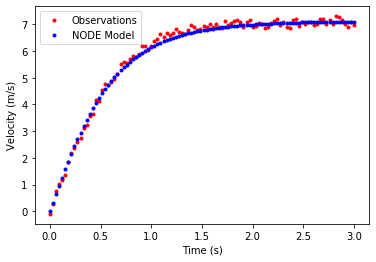

Iter 1900 | Total Loss 0.113424


In [46]:
# Use euler to match Aidan's example. You can use a more sophisticated method for a more complex problem.
method = 'euler'
model = ODEFunc()

optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

for itr in range(2000):
    
    optimizer.zero_grad()
    
    # Get initial state, time steps, true y values at each timestep.
    batch_y0, batch_t, batch_y = get_batch(h_train, times)

    # Use NODE to integrate forward
    pred_y = odeint_nn(model, batch_y0, batch_t)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if itr % 100 == 0:
        clear_output(wait=True)
        with torch.no_grad():
            
            pred_y = odeint_nn(model, torch.Tensor([0]), torch.Tensor(times), method=method)
            loss = torch.mean(torch.abs(pred_y - torch.Tensor(h_train)))
            plt.plot(times, h_train, '.r', label='Observations')
            plt.plot(times, pred_y, '.b', label='NODE Model')
            plt.xlabel('Time (s)')
            plt.ylabel('Velocity (m/s)')
            plt.legend()
            plt.show()
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))